Архитектура генеративно-состязательных сетей (GAN)
#### Основные применения:
1. Применение GAN: Генеративно-состязательные сети находят применение в различных областях, включая 3D-моделирование объектов, медицину, обработку изображений, распознавание лиц, перенос текстур и управление дорожным движением.
2. Преимущества GAN: Одной из ключевых особенностей GAN является их способность генерировать высококачественные данные, что делает их особенно полезными для задач, требующих детализированного воспроизведения или улучшения изображений.
3. Использование в медицине: В медицинской сфере GAN используются для улучшения качества медицинских изображений, моделирования распространения болезней и создания трехмерных медицинских моделей для планирования операций.

#### Проблемы и вызовы:
1. Трудности с обучением: GAN сложно обучать из-за нестабильности процесса, когда две сети (генератор и дискриминатор) конкурируют друг с другом.
2. Высокие требования к ресурсам: Для обучения GAN требуются значительные вычислительные ресурсы, особенно для задач, связанных с обработкой больших данных.

#### Перспективы развития:
Есть необходимость дальнейшего исследования методов оптимизации процесса обучения GAN, чтобы сделать их более доступными и эффективными для широкого круга приложений. Также нужно акцентрировать внимание на разработке новых моделей, которые могли бы решить проблему нестабильности обучения и повысить качество генерируемых данных.

## Применение архитектуры генеративно-состязательных сетей (GAN) возможно для выявления брака на фотографиях в заводском процессе выпуска листов стали. Вот как это может быть реализовано:

In [8]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from PIL import Image
import os

# Загрузка данных
data_path = 'train.csv'
images_folder = 'train_images'
data = pd.read_csv(data_path)
image_size = (128, 128)

# Подготовка изображений
def load_images(data, images_folder):
    loaded_images = []
    image_paths = data['ImageId'].values  # Используем столбец 'ImageId' для определения путей к изображениям
    for img_path in image_paths:
        full_path = os.path.join(images_folder, img_path)
        if os.path.exists(full_path):  # Проверка существования файла
            image = Image.open(full_path).resize(image_size)
            loaded_images.append(np.array(image))
        else:
            print(f"Warning: Image {full_path} not found.")
    return np.array(loaded_images)

images = load_images(data, images_folder)
images = images.astype('float32') / 255.0

# Архитектура генератора
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(256, activation='relu', input_dim=100),
        layers.Reshape((4, 4, 16)),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', activation='relu'),  # размер будет 8x8
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),   # размер будет 16x16
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),   # размер будет 32x32
        layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', activation='relu'),   # размер будет 64x64
        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='sigmoid')  # размер будет 128x128
    ])
    return model


# Архитектура дискриминатора
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(128, 128, 3)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Создание и компиляция моделей
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False
gan_input = layers.Input(shape=(100,))
fake_image = generator(gan_input)
gan_output = discriminator(fake_image)
gan = tf.keras.models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Функция обучения
def train_gan(generator, discriminator, gan, images, epochs=10, batch_size=128):
    noise_dim = 100
    half_batch = int(batch_size / 2)
    for epoch in range(epochs):
        for batch_idx in range(0, len(images), batch_size):
            real_images = images[batch_idx:batch_idx+half_batch]
            real_labels = np.ones((half_batch, 1))
            noise = np.random.normal(0, 1, (half_batch, noise_dim))
            fake_images = generator.predict(noise)
            fake_labels = np.zeros((half_batch, 1))
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            misleading_targets = np.ones((batch_size, 1))
            g_loss = gan.train_on_batch(noise, misleading_targets)
        print(f'Epoch: {epoch+1}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}')



c:\Users\chern\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\chern\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [ ]:
# Начать обучение (пример)
train_gan(generator, discriminator, gan, images, epochs=10, batch_size=32)

## Cегментация по дефектам

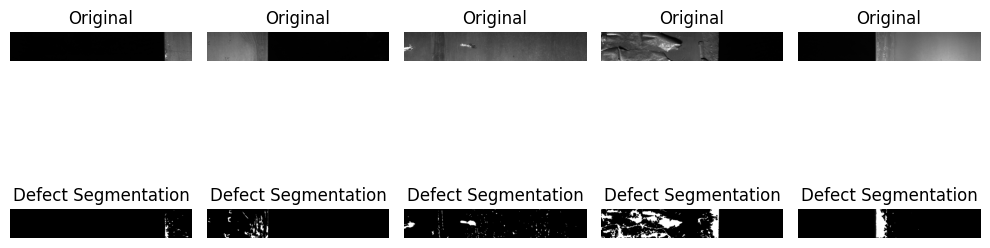

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Функция для сегментации по дефектам
def defect_segmentation(image):
    # Преобразование изображения в оттенки серого
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Применение фильтра Кэнни для обнаружения краев
    edges = cv2.Canny(gray, 50, 150)
    
    # Применение морфологических операций для улучшения обнаруженных контуров
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    
    # Нахождение контуров дефектов
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Создание маски для дефектов
    defect_mask = np.zeros_like(gray)
    for contour in contours:
        cv2.drawContours(defect_mask, [contour], -1, (255), thickness=cv2.FILLED)
    
    return defect_mask

# Проходим по изображениям в папке train_images и выполняем сегментацию по дефектам
data_dir = 'train_images'
defect_masks = []
for filename in os.listdir(data_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(data_dir, filename)
        image = cv2.imread(image_path)
        defect_mask = defect_segmentation(image)
        defect_masks.append(defect_mask)

# Отображаем несколько примеров результатов сегментации
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(data_dir, os.listdir(data_dir)[i])), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original')
    
    plt.subplot(2, 5, i+6)
    plt.imshow(defect_masks[i], cmap='gray')
    plt.axis('off')
    plt.title('Defect Segmentation')

plt.tight_layout()
plt.show()


## Сегментация по текстуре

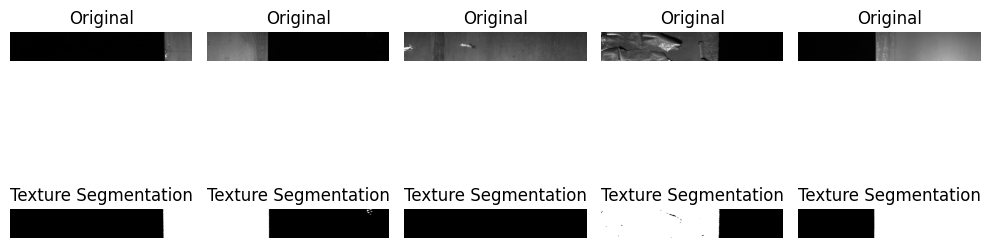

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Функция для сегментации по текстуре с использованием фильтров Габора
def texture_segmentation(image):
    # Преобразование изображения в оттенки серого
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Создание банка фильтров Габора
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 4):
        for sigma in (1, 3):
            gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
            filters.append(gabor_kernel)
    
    # Применение фильтров Габора к изображению
    filtered_images = [cv2.filter2D(gray, cv2.CV_8UC3, kernel) for kernel in filters]
    
    # Выбор наилучшего отфильтрованного изображения
    best_filtered_image = max(filtered_images, key=cv2.mean)
    
    # Бинаризация изображения для создания маски текстуры
    _, texture_mask = cv2.threshold(best_filtered_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    return texture_mask

# Проходим по изображениям в папке train_images и выполняем сегментацию по текстуре
data_dir = 'train_images'
texture_masks = []
for filename in os.listdir(data_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(data_dir, filename)
        image = cv2.imread(image_path)
        texture_mask = texture_segmentation(image)
        texture_masks.append(texture_mask)

# Отображаем несколько примеров результатов сегментации
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(data_dir, os.listdir(data_dir)[i])), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original')
    
    plt.subplot(2, 5, i+6)
    plt.imshow(texture_masks[i], cmap='gray')
    plt.axis('off')
    plt.title('Texture Segmentation')

plt.tight_layout()
plt.show()
